<a href="https://colab.research.google.com/github/clawrencia/COMP90042_Project/blob/main/NLP_Project_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK 2: COVID-19 Topics Extraction and Sentiment Analysis

In [ ]:
#Mount to G-Drive Files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gensim
!pip install 'nltk==3.4.5'
!pip install tweet-preprocessor
!pip install TextBlob


     |████████████████████████████████| 1.5MB 6.8MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp37-none-any.whl size=1449910 sha256=a0ce406ee4933360defb8eb606279e6c48b56989bf6843c3f708c747c188b822
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


Topic Extraction Using LDA

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import preprocessor as p
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:

import json 
import pandas as pd

covid_data_labelled = '/content/drive/MyDrive/Data/covid-labelledv2.json'

In [ ]:
#Importing the labelled covid file

def load_feat_df(file_path):
  line_list = []
  with open(file_path) as f:
      for line in f:
        a_dict= json.loads(line)
        df = pd.DataFrame(a_dict)
        line_list.append(df)

  df = pd.concat(line_list)
  return df
covid_df=load_feat_df(covid_data_labelled)

#Display Size of Data
print(covid_df.shape)

(17458, 4)


In [ ]:
#Separate Rumour and Non-Rumour Data into 2 different dataframes

def separate_labels(dataframe):
  rumour =pd.DataFrame(columns=['id_str','text','reply_text'])
  nonrumour = pd.DataFrame(columns=['id_str','text','reply_text'])

  for index,rows in dataframe.iterrows():
    if rows[3] == 'rumour':
      rumour = rumour.append(rows,ignore_index=True)
      
    else:
      nonrumour = nonrumour.append(rows,ignore_index=True)
 
  return rumour,nonrumour

rumour_df, non_rumour_df =separate_labels(covid_df)

In [ ]:
#Checking the size of Rumour and Non-Rumour Data
rumour_df.shape
non_rumour_df.shape

(9477, 4)

In [ ]:
#Combine the Main Text and Reply Text 
def combine_text(dataframe):
  dataframe['text'] = dataframe['text'].fillna('-')
  dataframe['reply_text'] = dataframe['reply_text'].fillna('-')
  dataframe['combined'] = dataframe['text'].astype(str)+"-"+dataframe['reply_text'].astype(str)

  return dataframe

rumour_df_combined = combine_text(rumour_df)
nonrumour_df_combined = combine_text(non_rumour_df)

In [ ]:
#Assigning the stop words for preprocessing 
#Add punctuations as a part of stop words
stop_words = stopwords.words('english')
stop_words += list(string.punctuation)

lemmatizer = WordNetLemmatizer()

#A function to fix encoding errors
def fix_encode(text):
  text = text.replace(r'&amp;',r'and')
  text = text.replace(r'&lt;',r'<')
  text = text.replace(r'&gt;',r'>')

  return text

#A function to tokenize the text
def tokenize_text(text):
  tokens = word_tokenize(text)
  tokens_stopwords_none = [t.lower() for t in tokens if t.lower() not in stop_words]
  return tokens_stopwords_none

#Remove all punctuations except for #
def remove_punctuations(text):
  punctuation_list = string.punctuation.replace("#", "")
  text = text.translate(str.maketrans('', '', punctuation_list))
  return text

#Remove all emojis, smileys, and url 
def clean_text(text):
  p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.SMILEY)
  text = p.clean(str(text))
  return text

#A function to lemmatize text
def lemmatize_text(text):
    lemmatized=[]
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

rumour_text = rumour_df_combined['combined']
nonrumour_text = nonrumour_df_combined['combined']

rumour_text = rumour_text.apply(clean_text)
rumour_text = rumour_text.apply(fix_encode)
rumour_text = rumour_text.apply(remove_punctuations)
rumour_text = rumour_text.apply(tokenize_text)
rumour_text = rumour_text.apply(lemmatize_text)

nonrumour_text = nonrumour_text.apply(clean_text)
nonrumour_text = nonrumour_text.apply(fix_encode)
nonrumour_text = nonrumour_text.apply(remove_punctuations)
nonrumour_text = nonrumour_text.apply(tokenize_text)
nonrumour_text = nonrumour_text.apply(lemmatize_text)


In [ ]:
#convert rumour and non-rumour tokenized words into bag of words
rumour_text_dict = Dictionary(rumour_text)
nonrumour_text_dict = Dictionary(nonrumour_text)

rumour_bagofwords = [rumour_text_dict.doc2bow(tweet) for tweet in rumour_text]
nonrumour_bagofwords = [nonrumour_text_dict.doc2bow(tweet) for tweet in nonrumour_text]

In [ ]:

#Loop through to find the optimum k-value for rumour and non-rumour

rumour_score=[]
nonrumour_score=[]
for k in range(15):
  index = k+1

  rumour_lda = LdaModel(rumour_bagofwords,
                      num_topics = index,
                      id2word = rumour_text_dict,
                      random_state =1,
                      passes=2,
                      chunksize=100)

  nonrumour_lda = LdaModel(nonrumour_bagofwords,
                      num_topics = index,
                      id2word = nonrumour_text_dict,
                      random_state =1,
                      passes=2,
                      chunksize=100)

  coherence_model_lda_rum = CoherenceModel(model=rumour_lda, texts=rumour_text, dictionary=rumour_text_dict, coherence='c_v')
  coherence_lda_rum = coherence_model_lda_rum.get_coherence()
  rumour_score.append(coherence_lda_rum)

  coherence_model_lda_nonrum = CoherenceModel(model=rumour_lda, texts=nonrumour_text, dictionary=nonrumour_text_dict, coherence='c_v')
  coherence_lda_nonrum = coherence_model_lda_nonrum.get_coherence()
  nonrumour_score.append(coherence_lda_nonrum)
  print(index)
 


In [ ]:
for i in rumour_score:
  print(i)

for j in nonrumour_score:
  print(j)

In [ ]:
#LDA Model based on the optimized K
rumour_lda = LdaModel(rumour_bagofwords,
                      num_topics = 13,
                      id2word = rumour_text_dict,
                      random_state =1,
                      passes=2,
                      chunksize=100)

nonrumour_lda = LdaModel(nonrumour_bagofwords,
                      num_topics = 8,
                      id2word = nonrumour_text_dict,
                      random_state =1,
                      passes=2,
                      chunksize=100)

coherence_model_lda_rum = CoherenceModel(model=rumour_lda, texts=rumour_text, dictionary=rumour_text_dict, coherence='c_v')
coherence_lda_rum = coherence_model_lda_rum.get_coherence()


coherence_model_lda_nonrum = CoherenceModel(model=rumour_lda, texts=nonrumour_text, dictionary=nonrumour_text_dict, coherence='c_v')
coherence_lda_nonrum = coherence_model_lda_nonrum.get_coherence()

In [ ]:
#Show the topics obtained from the LDA model

rumour_topics = rumour_lda.show_topics()
nonrumour_topics = nonrumour_lda.show_topics()

rumour_topics_dict = {'Topic_' + str(i+1): [token for token, score in rumour_lda.show_topic(i, topn=15)] for i in range(0, rumour_lda.num_topics)}
nonrumour_topics_dict = {'Topic_' + str(i+1): [token for token, score in nonrumour_lda.show_topic(i, topn=15)] for i in range(0, nonrumour_lda.num_topics)}



print('Rumour Topics')
print(rumour_topics_dict)
print("===================")
print('Non-Rumour Topics')
print(nonrumour_topics_dict)

Rumour Topics
{'Topic_1': ['covid19', 'coronavirus', 'u', 'country', 'pandemic', 'people', 'world', 'case', 'day', 'testing', 'test', 'one', 'state', 'help', 'time'], 'Topic_2': ['getusppe', 'covid19', 'ncdcgov', 'yo', 'gregabbotttx', 'nigeria', 'ochocinco', 'god', 'washingtonpost', 'help', 'fmohnigeria', 'fmicnigeria', 'thecableng', 'state', 'kogifacts'], 'Topic_3': ['covid19', 'coronavirus', 'people', 'get', 'mask', 'dont', 'like', 'one', 'go', 'going', 'want', 'virus', 'spread', 'know', 'think'], 'Topic_4': ['covid19', 'positive', 'pmoindia', 'jdawsey1', 'tested', 'drharshvardhan', 'mohfwindia', 'hospitalsapollo', 'aiimsnewdelhi', 'drsangitareddy', 'india', 'chrismegerian', 'kategarraway', 'skynews', 'derekdraper'], 'Topic_5': ['covid19', 'oann', 'coronavirus', 'died', 'hospital', 'healthcareheroes', 'know', 'people', 'old', 'year', 'family', 'symptom', 'child', 'nurse', 'doctor'], 'Topic_6': ['bbclaurak', 'maddow', 'cummings', 'joyannreid', 'lockdown', 'ingrahamangle', 'narendramod

In [ ]:
pd.DataFrame.from_dict(rumour_topics_dict)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13
0,covid19,getusppe,covid19,covid19,covid19,bbclaurak,trump,covid19,covid19,realdonaldtrump,death,china,feb
1,coronavirus,covid19,coronavirus,positive,oann,maddow,coronavirus,cnn,coronavirus,trump,covid19,coronavirus,ryanstruyk
2,u,ncdcgov,people,pmoindia,coronavirus,cummings,mikepence,patient,government,coronavirus,case,virus,aslavitt
3,country,yo,get,jdawsey1,died,joyannreid,penny,nursing,toryboypierce,american,number,wuhan,seanhannity
4,pandemic,gregabbotttx,mask,tested,hospital,lockdown,acosta,home,matthancock,president,coronavirus,chinese,jan
5,people,nigeria,dont,drharshvardhan,healthcareheroes,ingrahamangle,vp,nygovcuomo,piersmorgan,covid19,died,world,jenniferjjacobs
6,world,ochocinco,like,mohfwindia,know,narendramodi,white,coronavirus,uk,u,brithume,lab,antonioguterres
7,case,god,one,hospitalsapollo,people,model,replouiegohmert,vaccine,lockdown,pandemic,new,wuhanvirus,mar
8,day,washingtonpost,go,aiimsnewdelhi,old,mile,house,dr,people,people,people,ccp,kylegriffin1
9,testing,help,going,drsangitareddy,year,india,politico,texas,home,foxnews,rate,realjameswoods,position


In [ ]:
pd.DataFrame.from_dict(nonrumour_topics_dict)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8
0,covid19,covid19,covid19,narendramodi,realdonaldtrump,coronavirus,covid19,covid19
1,mask,coronavirus,american,covid19,coronavirus,covid19,nygovcuomo,trump
2,tesla,death,trump,india,trump,people,home,coronavirus
3,people,government,people,brianstelter,covid19,virus,nursing,death
4,social,uk,coronavirus,sir,american,like,patient,u
5,distancing,people,case,contest,death,dont,state,whitehouse
6,vaccine,lockdown,realdonaldtrump,drtedros,president,get,ncgovernor,american
7,take,school,death,student,u,china,governor,people
8,wear,borisjohnson,dead,exam,foxnews,u,new,pandemic
9,get,child,vote,please,seanhannity,know,would,state


Sentiment Analysis Using TextBlob


In [ ]:
#Cleaning of the data
rumour_text_sentiment = rumour_df_combined
nonrumour_text_sentiment = nonrumour_df_combined

rumour_text_sentiment['combined'] = rumour_text_sentiment['combined'].apply(clean_text)
rumour_text_sentiment['combined'] = rumour_text_sentiment['combined'].apply(fix_encode)
rumour_text_sentiment['combined'] = rumour_text_sentiment['combined'].apply(remove_punctuations)

nonrumour_text_sentiment['combined'] = nonrumour_text_sentiment['combined'].apply(clean_text)
nonrumour_text_sentiment['combined'] = nonrumour_text_sentiment['combined'].apply(fix_encode)
nonrumour_text_sentiment['combined'] = nonrumour_text_sentiment['combined'].apply(remove_punctuations)

In [ ]:
#A function to measure the subjectivity
def textSubjectivity(tweet):
  return TextBlob(tweet).sentiment.subjectivity

rumour_text_sentiment['subjectivity'] = rumour_text_sentiment['combined'].apply(textSubjectivity)
nonrumour_text_sentiment['subjectivity'] = nonrumour_text_sentiment['combined'].apply(textSubjectivity)

In [ ]:
nonrumour_text_sentiment.head()

,id_str,text,reply_text,label,combined,subjectivity
0,1257715199655755779,Eastleigh and Swahili Arabs in Mombasa where c...,@BelAkinyii Let's not play blind that the work...,non-rumour,Eastleigh and Swahili Arabs in Mombasa where c...,0.406667
1,1249421782630772746,Today Im thinking about the families across ou...,@KamalaHarris @donnabrazile That is the dumbes...,non-rumour,Today Im thinking about the families across ou...,0.500000
2,1274091468890632192,KHive has become the most toxic thing on Twitt...,@JasonOverstreet It wasn't enough that Warren'...,non-rumour,KHive has become the most toxic thing on Twitt...,0.520000
3,1278159404324405248,Major League Soccer COVID-19 Testing Update - ...,-,non-rumour,Major League Soccer COVID19 Testing Update June,0.500000
4,1275627556289511424,New Harris County numbers online tonight . For...,@PeterHotez @HoustonChron @NewDay @CNN I'm ver...,non-rumour,New Harris County numbers online tonight Forg...,0.652424


In [ ]:
# A function to measure the polarity
def textPolarity(tweet):
  return TextBlob(tweet).sentiment.polarity
rumour_text_sentiment['polarity'] = rumour_text_sentiment['combined'].apply(textPolarity)
nonrumour_text_sentiment['polarity'] = nonrumour_text_sentiment['combined'].apply(textPolarity)

In [ ]:
#A function to label the sentiment
def defineSentiment(polarity_score):
  score = 'Neutral'
  if polarity_score < 0:
    score = 'Negative'
  elif polarity_score > 0:
    score = 'Positive'
  return score

rumour_text_sentiment['score'] = rumour_text_sentiment['polarity'].apply(defineSentiment)
nonrumour_text_sentiment['score'] = nonrumour_text_sentiment['polarity'].apply(defineSentiment)

In [ ]:
labels_nr = nonrumour_text_sentiment.groupby('score').count().index.values

values_nr = nonrumour_text_sentiment.groupby('score').size().values

labels_r = rumour_text_sentiment.groupby('score').count().index.values

values_r = rumour_text_sentiment.groupby('score').size().values

#plt.bar(labels_r, values_r)
#plt.bar(labels_nr, values_nr)

print(labels_r)
print(values_r)



['Negative' 'Neutral' 'Positive']
[2443  616 4922]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


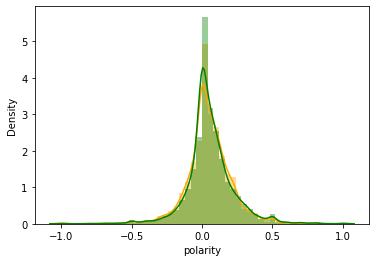

In [ ]:
sns.distplot(rumour_text_sentiment["polarity"],color='orange')
sns.distplot(nonrumour_text_sentiment["polarity"],color='green')
